## Importing the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
sns.set()

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [3]:
df_comp['market_value']=df_comp.ftse

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [5]:
import warnings
warnings.filterwarnings("ignore")

## The LLR Test

In [6]:
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

## Creating Returns

In [7]:
df['returns'] = df.market_value.pct_change(1)*100

## ARMA(1,1)

In [8]:
ar1_ma1_ret_model=ARIMA(df['returns'],order=(1,0,1))
ar1_ma1_ret_result=ar1_ma1_ret_model.fit()
ar1_ma1_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7916.500
Date:                Sun, 17 Jul 2022   AIC                          15841.000
Time:                        22:11:27   BIC                          15867.085
Sample:                    01-07-1994   HQIC                         15850.140
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1          0.7650      0.045     16.995      0.000       0.677       0.853
ma.L1         -0.8142      0.040    -20.187      0.000      -0.893      -0.735
sigma2         1.3718      0.014     98.110      0.000       1.344       1.399
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):              7494.88
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# So the p values are significant for coefficients
# AR coeff is positive and MA is negative
# Positive AR value states that returns move in consecutive positive and negatives, ie periods of consistent 
# increase or decrease when translated to prices

# Negative MA shows that we should be moving away from past period values rather than using them targets for 
# calibration. These past error terms shows that we dont want to get into 'fool into shower errors.'

In [10]:
# We should fit the AR and MA model individually and try the LLR test to check if ARMA(1,1) is useful.

In [11]:
ar1_ret_model=ARIMA(df['returns'],order=(1,0,0))
ma1_ret_model=ARIMA(df['returns'],order=(0,0,1))
print("AR VS ARMA",LLR_test(ar1_ret_model,ar1_ma1_ret_model))
print("MA VS ARMA",LLR_test(ma1_ret_model,ar1_ma1_ret_model))

# The df value here is one, since ARMA has df 2, and AR and MA have 1,1 each so net DF is 1.

AR VS ARMA 0.0
MA VS ARMA 0.0


In [12]:
# This can be interpreted as ARMA model performed better than AR and MA models. So past values and past errors 
# perform better.

## Higher-Lag ARMA Models

In [13]:
# Quickky plot the ACF and PACF
# While fitting higher lag model, we move backwards from high values, we plot PACF and ACF and take high values
# and then come backwards trying to find the best model where 
# 1- all coeff are statistically significant
# 2- high log likelihood
# 3- Low information criteria

(-0.08, 0.08)

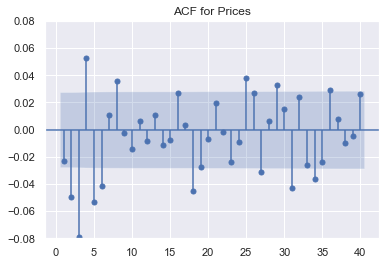

In [14]:
sgt.plot_acf(df['returns'][1:],lags=40,zero=False)
plt.title("ACF for Prices")
plt.ylim(-0.08,0.08)

(-0.08, 0.08)

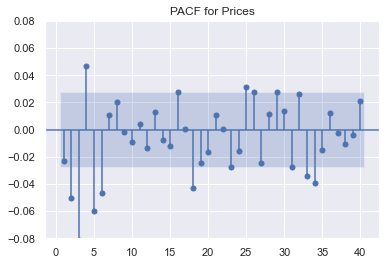

In [15]:
sgt.plot_pacf(df['returns'][1:],lags=40,zero=False,method=('ols'))
plt.title("PACF for Prices")
plt.ylim(-0.08,0.08)

In [16]:
# So here we see 8 lags for ACF(MA) and 6 lags for PACF(AR) are significant.

In [17]:
# But ARMA(6,8) can be more complex and many of the coefficients might be insignificant thus we take ARMA(3,3)
# as the starting point

In [18]:
ar6_ma8_ret_model=ARIMA(df['returns'],order=(6,0,8))
ar6_ma8_ret_result=ar6_ma8_ret_model.fit()
ar6_ma8_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(6, 0, 8)   Log Likelihood               -7881.971
Date:                Sun, 17 Jul 2022   AIC                          15795.943
Time:                        22:11:41   BIC                          15900.285
Sample:                    01-07-1994   HQIC                         15832.505
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.015      1.282      0.200      -0.010       0.048
ar.L1         -0.3062      0.138     -2.226      0.026      -0.576      -0.037
ar.L2         -0.5341      0.114     -4.695      0.000      -0.757      -0.311
ar.L3          0.4894      0.151      3.232      0.001       0.193       0.786
ar.L4          0.1559      0.091      1.708      0.088      -0.023       0.335
ar.L5          0.6967      0.080      8.736      0.000       0.540       0.853
ar.L6          0.2000      0.079      2.536      0.011       0.045       0.355
ma.L1          0.2823      0.138      2.052      0.040       0.013       0.552
ma.L2          0.4774      0.114      4.202      0.000       0.255       0.700
ma.L3         -0.6022      0.146     -4.123      0.000      -0.888      -0.316
ma.L4         -0.1470      0.092     -1.591      0.112      -0.328       0.034
ma.L5         -0.7437      0.076     -9.756      0.000      -0.893      -0.594
ma.L6         -0.1548      0.084     -1.841      0.066      -0.320       0.010
ma.L7          0.0106      0.015      0.715      0.475      -0.019       0.040
ma.L8          0.1010      0.016      6.432      0.000       0.070       0.132
sigma2         1.3530      0.015     91.166      0.000       1.324       1.382
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6519.13
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
ar6_ma8_ret_model=ARIMA(df['returns'],order=(3,1,1))
ar6_ma8_ret_result=ar6_ma8_ret_model.fit()
ar6_ma8_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -7917.901
Date:                Mon, 18 Jul 2022   AIC                          15845.801
Time:                        15:14:16   BIC                          15878.407
Sample:                    01-07-1994   HQIC                         15857.227
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0281      0.009     -3.150      0.002      -0.046      -0.011
ar.L2         -0.0519      0.008     -6.644      0.000      -0.067      -0.037
ar.L3         -0.0813      0.008     -9.914      0.000      -0.097      -0.065
ma.L1         -1.0000      0.017    -60.568      0.000      -1.032      -0.968
sigma2         1.3667      0.025     53.860      0.000       1.317       1.416
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              6871.02
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
ar6_ma8_ret_result.pvalues[:-1]

ar.L1    1.634762e-03
ar.L2    3.050315e-11
ar.L3    3.611115e-23
ma.L1    0.000000e+00
dtype: float64

In [19]:
# We see that many coeff are not significant thus we take ARMA (3,3)

In [20]:
ar3_ma3_ret_model=ARIMA(df['returns'],order=(3,0,3))
ar3_ma3_ret_result=ar3_ma3_ret_model.fit()
ar3_ma3_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7893.515
Date:                Sun, 17 Jul 2022   AIC                          15803.030
Time:                        22:11:44   BIC                          15855.201
Sample:                    01-07-1994   HQIC                         15821.311
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.281      0.200      -0.010       0.048
ar.L1         -0.1880      0.068     -2.780      0.005      -0.321      -0.055
ar.L2         -0.2926      0.054     -5.380      0.000      -0.399      -0.186
ar.L3          0.4469      0.062      7.253      0.000       0.326       0.568
ma.L1          0.1690      0.063      2.686      0.007       0.046       0.292
ma.L2          0.2260      0.052      4.328      0.000       0.124       0.328
ma.L3         -0.5442      0.056     -9.632      0.000      -0.655      -0.433
sigma2         1.3591      0.015     92.543      0.000       1.330       1.388
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              6867.96
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
(ar3_ma3_ret_result.pvalues[1:-1]>0.05).sum()

0

In [21]:
# We observe that all the coefficients are significant

In [22]:
LLR_test(ar1_ma1_ret_model,ar3_ma3_ret_model,DF=4)

0.0

In [23]:
# Here we will try ARMA(3,2) and ARMA(2,3)

In [24]:
ar3_ma2_ret_model=ARIMA(df['returns'],order=(3,0,2))
ar3_ma2_ret_result=ar3_ma2_ret_model.fit()
ar3_ma2_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7895.747
Date:                Sun, 17 Jul 2022   AIC                          15805.495
Time:                        22:11:50   BIC                          15851.145
Sample:                    01-07-1994   HQIC                         15821.491
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.211      0.226      -0.012       0.049
ar.L1         -0.6778      0.055    -12.298      0.000      -0.786      -0.570
ar.L2         -0.5082      0.063     -8.035      0.000      -0.632      -0.384
ar.L3         -0.1141      0.009    -12.755      0.000      -0.132      -0.097
ma.L1          0.6561      0.056     11.747      0.000       0.547       0.766
ma.L2          0.4468      0.064      7.031      0.000       0.322       0.571
sigma2         1.3604      0.015     91.796      0.000       1.331       1.389
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6518.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Now here all the coeff are statistically significant.
# Also we observe that ar coeff are negative which explains the market behavior that if the value is high
# it is tend to come down
# Also the positive ma value means something. If our prediction was lower than actual than residual was positive
# and positive ma coeff means the net product is positive which means its trying to increase the prediction to 
# actual level. If the prediction is higher, residual is negative, so product is negative and it tries to bring the
# prediction to lower level

In [26]:
ar2_ma3_ret_model=ARIMA(df['returns'],order=(2,0,3))
ar2_ma3_ret_result=ar2_ma3_ret_model.fit()
ar2_ma3_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7895.587
Date:                Sun, 17 Jul 2022   AIC                          15805.175
Time:                        22:11:53   BIC                          15850.824
Sample:                    01-07-1994   HQIC                         15821.171
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.015      1.224      0.221      -0.011       0.049
ar.L1         -0.5600      0.057     -9.777      0.000      -0.672      -0.448
ar.L2         -0.4178      0.065     -6.381      0.000      -0.546      -0.289
ma.L1          0.5373      0.057      9.417      0.000       0.425       0.649
ma.L2          0.3531      0.066      5.383      0.000       0.225       0.482
ma.L3         -0.1159      0.009    -12.679      0.000      -0.134      -0.098
sigma2         1.3604      0.015     91.315      0.000       1.331       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6520.56
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
LLR_test(ar2_ma3_ret_model,ar3_ma3_ret_model)

0.042

In [28]:
LLR_test(ar3_ma2_ret_model,ar3_ma3_ret_model)

0.035

In [29]:
#LLR_test(ar2_ma3_ret_model,ar3_ma2_ret_model) 

# Also remember to put the simpler model first
# You can test ARMA models when the first one is nested inside the second one
# ARMA(p1,q1) is nested inside ARMA(p2,q2) when
# p1+q1 < p2+q2
# p1 <= p2
# q1 <= q2

In [30]:
ar3_ma1_ret_model=ARIMA(df['returns'],order=(3,0,1))
ar3_ma1_ret_result=ar3_ma1_ret_model.fit()
ar3_ma1_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7899.072
Date:                Sun, 17 Jul 2022   AIC                          15810.144
Time:                        22:12:05   BIC                          15849.273
Sample:                    01-07-1994   HQIC                         15823.855
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.248      0.212      -0.011       0.048
ar.L1         -0.5074      0.062     -8.155      0.000      -0.629      -0.385
ar.L2         -0.0638      0.009     -7.027      0.000      -0.082      -0.046
ar.L3         -0.1102      0.008    -13.610      0.000      -0.126      -0.094
ma.L1          0.4836      0.064      7.608      0.000       0.359       0.608
sigma2         1.3623      0.015     92.782      0.000       1.334       1.391
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6495.86
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
LLR_test(ar3_ma1_ret_model,ar3_ma2_ret_model)

0.01

In [32]:
ar2_ma2_ret_model=ARIMA(df['returns'],order=(2,0,2))
ar2_ma2_ret_result=ar2_ma2_ret_model.fit()
ar2_ma2_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7914.692
Date:                Sun, 17 Jul 2022   AIC                          15841.384
Time:                        22:12:11   BIC                          15880.512
Sample:                    01-07-1994   HQIC                         15855.095
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.290      0.197      -0.010       0.048
ar.L1         -0.0969      0.091     -1.068      0.286      -0.275       0.081
ar.L2          0.6975      0.066     10.509      0.000       0.567       0.828
ma.L1          0.0399      0.092      0.435      0.663      -0.140       0.220
ma.L2         -0.7259      0.071    -10.274      0.000      -0.864      -0.587
sigma2         1.3708      0.014     95.248      0.000       1.343       1.399
===================================================================================
Ljung-Box (L1) (Q):                   4.33   Jarque-Bera (JB):              7242.98
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Here the first lag in both AR and MA is not significant
# thus we avoid this one

In [34]:
ar1_ma3_ret_model=ARIMA(df['returns'],order=(1,0,3))
ar1_ma3_ret_result=ar1_ma3_ret_model.fit()
ar1_ma3_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7896.838
Date:                Sun, 17 Jul 2022   AIC                          15805.676
Time:                        22:12:12   BIC                          15844.804
Sample:                    01-07-1994   HQIC                         15819.387
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.265      0.206      -0.010       0.048
ar.L1         -0.4693      0.060     -7.878      0.000      -0.586      -0.353
ma.L1          0.4469      0.060      7.437      0.000       0.329       0.565
ma.L2         -0.0637      0.009     -7.277      0.000      -0.081      -0.047
ma.L3         -0.1182      0.008    -14.693      0.000      -0.134      -0.102
sigma2         1.3610      0.015     92.540      0.000       1.332       1.390
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6406.69
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
print("ar1_ma3 \t LLF",ar1_ma3_ret_result.llf,"\tAIC:",ar1_ma3_ret_result.aic)
print("ar3_ma2\t LLF",ar3_ma2_ret_result.llf,"\tAIC:",ar3_ma2_ret_result.aic)

ar1_ma3 	 LLF -7896.83790920578 	AIC: 15805.67581841156
ar3_ma2	 LLF -7895.747490025016 	AIC: 15805.494980050033


## Residuals for Returns

In [36]:
df['ar3_ma2_ret_resid']=ar3_ma2_ret_result

In [37]:
df['ar3_ma2_ret_resid']=ar3_ma2_ret_result.resid

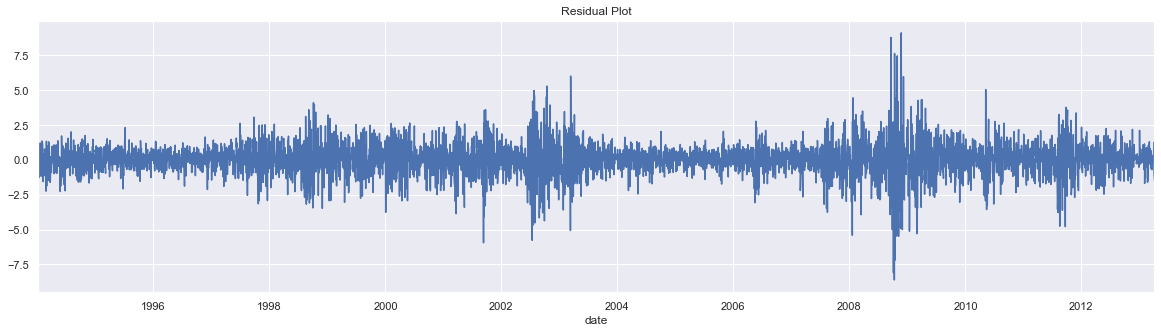

In [38]:
df['ar3_ma2_ret_resid'].plot(figsize=(20,5))
plt.title("Residual Plot")
plt.show()

In [39]:
# this plot looks similar to MA and AR model noise and thus maybe its not able to adjust to shocks
df['ar3_ma2_ret_resid'].mean()

-8.98853776570982e-06

In [40]:
df['ar3_ma2_ret_resid'].var()

1.360746191011428

(-0.06, 0.06)

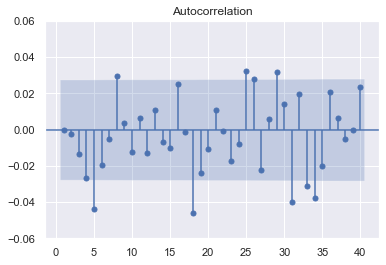

In [41]:
sgt.plot_acf(df['ar3_ma2_ret_resid'][1:],lags=40,zero=False)
plt.ylim(-0.06,0.06)

In [42]:
# We can see that 5th lag is significant and we havent included that in ARMA model.
# Now we will run ARMA (5,5)

## Reevaluating Model Selection

In [43]:
ar5_ma5_ret_model=ARIMA(df['returns'],order=(5,0,5))
ar5_ma5_ret_result=ar5_ma5_ret_model.fit()
ar5_ma5_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7883.611
Date:                Sun, 17 Jul 2022   AIC                          15791.223
Time:                        22:12:20   BIC                          15869.480
Sample:                    01-07-1994   HQIC                         15818.645
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.015      1.310      0.190      -0.009       0.048
ar.L1          0.0226      0.130      0.174      0.862      -0.232       0.277
ar.L2         -0.4892      0.082     -5.987      0.000      -0.649      -0.329
ar.L3         -0.0355      0.073     -0.489      0.625      -0.178       0.107
ar.L4          0.2663      0.074      3.621      0.000       0.122       0.410
ar.L5          0.0804      0.093      0.860      0.390      -0.103       0.263
ma.L1         -0.0486      0.130     -0.375      0.708      -0.303       0.205
ma.L2          0.4430      0.083      5.359      0.000       0.281       0.605
ma.L3         -0.0552      0.071     -0.779      0.436      -0.194       0.084
ma.L4         -0.2408      0.073     -3.295      0.001      -0.384      -0.098
ma.L5         -0.1711      0.089     -1.920      0.055      -0.346       0.004
sigma2         1.3540      0.015     90.323      0.000       1.325       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              6535.81
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Taking 5 for both AR and MA is redundant and thus we should not take both as 5. Instead take combination of 
# (5,4),(5,3),(5,2),(5,1) and (4,5),(3,5),(2,5),(1,5)

In [45]:
ar5_ma4_ret_model=ARIMA(df['returns'],order=(5,0,4))
ar5_ma4_ret_result=ar5_ma4_ret_model.fit()
ar5_ma4_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -7883.865
Date:                Sun, 17 Jul 2022   AIC                          15789.730
Time:                        22:12:28   BIC                          15861.465
Sample:                    01-07-1994   HQIC                         15814.866
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.283      0.199      -0.010       0.048
ar.L1          0.1338      0.082      1.633      0.102      -0.027       0.294
ar.L2         -0.6066      0.080     -7.601      0.000      -0.763      -0.450
ar.L3         -0.1582      0.072     -2.205      0.027      -0.299      -0.018
ar.L4          0.2517      0.076      3.323      0.001       0.103       0.400
ar.L5         -0.1018      0.010    -10.002      0.000      -0.122      -0.082
ma.L1         -0.1590      0.082     -1.928      0.054      -0.321       0.003
ma.L2          0.5632      0.082      6.854      0.000       0.402       0.724
ma.L3          0.0667      0.070      0.947      0.343      -0.071       0.205
ma.L4         -0.2369      0.076     -3.112      0.002      -0.386      -0.088
sigma2         1.3541      0.015     92.013      0.000       1.325       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6470.40
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ar5_ma3_ret_model=ARIMA(df['returns'],order=(5,0,3))
ar5_ma3_ret_result=ar5_ma3_ret_model.fit()
ar5_ma3_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -7885.422
Date:                Sun, 17 Jul 2022   AIC                          15790.844
Time:                        22:12:33   BIC                          15856.058
Sample:                    01-07-1994   HQIC                         15813.695
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.280      0.201      -0.010       0.048
ar.L1          0.3341      0.082      4.095      0.000       0.174       0.494
ar.L2         -0.4768      0.077     -6.174      0.000      -0.628      -0.325
ar.L3         -0.0024      0.075     -0.032      0.974      -0.149       0.145
ar.L4          0.0525      0.011      4.756      0.000       0.031       0.074
ar.L5         -0.1067      0.011     -9.842      0.000      -0.128      -0.085
ma.L1         -0.3583      0.082     -4.391      0.000      -0.518      -0.198
ma.L2          0.4352      0.078      5.554      0.000       0.282       0.589
ma.L3         -0.0763      0.074     -1.031      0.302      -0.221       0.069
sigma2         1.3549      0.015     91.417      0.000       1.326       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6461.06
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
ar5_ma2_ret_model=ARIMA(df['returns'],order=(5,0,2))
ar5_ma2_ret_result=ar5_ma2_ret_model.fit()
ar5_ma2_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(5, 0, 2)   Log Likelihood               -7885.667
Date:                Sun, 17 Jul 2022   AIC                          15789.334
Time:                        22:12:37   BIC                          15848.026
Sample:                    01-07-1994   HQIC                         15809.900
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.286      0.198      -0.010       0.048
ar.L1          0.2971      0.079      3.746      0.000       0.142       0.453
ar.L2         -0.4726      0.077     -6.102      0.000      -0.624      -0.321
ar.L3         -0.0794      0.011     -7.210      0.000      -0.101      -0.058
ar.L4          0.0505      0.010      4.958      0.000       0.031       0.070
ar.L5         -0.1107      0.009    -12.039      0.000      -0.129      -0.093
ma.L1         -0.3208      0.079     -4.059      0.000      -0.476      -0.166
ma.L2          0.4297      0.079      5.439      0.000       0.275       0.585
sigma2         1.3552      0.015     92.455      0.000       1.326       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6390.35
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
ar5_ma1_ret_model=ARIMA(df['returns'],order=(5,0,1))
ar5_ma1_ret_result=ar5_ma1_ret_model.fit()
ar5_ma1_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -7889.311
Date:                Sun, 17 Jul 2022   AIC                          15794.623
Time:                        22:12:39   BIC                          15846.794
Sample:                    01-07-1994   HQIC                         15812.904
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.301      0.193      -0.010       0.047
ar.L1          0.3449      0.105      3.270      0.001       0.138       0.552
ar.L2         -0.0458      0.009     -4.852      0.000      -0.064      -0.027
ar.L3         -0.0651      0.010     -6.435      0.000      -0.085      -0.045
ar.L4          0.0742      0.012      6.092      0.000       0.050       0.098
ar.L5         -0.0813      0.009     -9.480      0.000      -0.098      -0.064
ma.L1         -0.3682      0.106     -3.461      0.001      -0.577      -0.160
sigma2         1.3570      0.015     92.269      0.000       1.328       1.386
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6474.21
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
LLR_test(ar5_ma1_ret_model,ar5_ma2_ret_model)

0.007

In [50]:
ar4_ma5_ret_model=ARIMA(df['returns'],order=(4,0,5))
ar4_ma5_ret_result=ar4_ma5_ret_model.fit()
ar4_ma5_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(4, 0, 5)   Log Likelihood               -7882.728
Date:                Sun, 17 Jul 2022   AIC                          15787.455
Time:                        22:12:51   BIC                          15859.191
Sample:                    01-07-1994   HQIC                         15812.592
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.284      0.199      -0.010       0.048
ar.L1          0.0222      0.081      0.273      0.785      -0.137       0.182
ar.L2         -0.6461      0.077     -8.377      0.000      -0.797      -0.495
ar.L3         -0.1539      0.071     -2.176      0.030      -0.293      -0.015
ar.L4          0.2070      0.074      2.796      0.005       0.062       0.352
ma.L1         -0.0461      0.081     -0.569      0.569      -0.205       0.113
ma.L2          0.5986      0.078      7.673      0.000       0.446       0.752
ma.L3          0.0536      0.068      0.785      0.432      -0.080       0.188
ma.L4         -0.1982      0.073     -2.717      0.007      -0.341      -0.055
ma.L5         -0.1055      0.010    -10.959      0.000      -0.124      -0.087
sigma2         1.3535      0.015     91.137      0.000       1.324       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6378.08
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
ar3_ma5_ret_model=ARIMA(df['returns'],order=(3,0,5))
ar3_ma5_ret_result=ar3_ma5_ret_model.fit()
ar3_ma5_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(3, 0, 5)   Log Likelihood               -7883.925
Date:                Sun, 17 Jul 2022   AIC                          15787.850
Time:                        22:12:57   BIC                          15853.064
Sample:                    01-07-1994   HQIC                         15810.702
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.259      0.208      -0.011       0.048
ar.L1         -0.1152      0.079     -1.456      0.145      -0.270       0.040
ar.L2         -0.8783      0.019    -45.281      0.000      -0.916      -0.840
ar.L3         -0.2645      0.072     -3.667      0.000      -0.406      -0.123
ma.L1          0.0912      0.079      1.152      0.249      -0.064       0.246
ma.L2          0.8251      0.022     36.855      0.000       0.781       0.869
ma.L3          0.1520      0.070      2.160      0.031       0.014       0.290
ma.L4         -0.0075      0.009     -0.809      0.419      -0.026       0.011
ma.L5         -0.1116      0.008    -13.139      0.000      -0.128      -0.095
sigma2         1.3535      0.015     90.625      0.000       1.324       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6231.25
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
ar2_ma5_ret_model=ARIMA(df['returns'],order=(2,0,5))
ar2_ma5_ret_result=ar2_ma5_ret_model.fit()
ar2_ma5_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(2, 0, 5)   Log Likelihood               -7884.688
Date:                Sun, 17 Jul 2022   AIC                          15787.375
Time:                        22:13:00   BIC                          15846.068
Sample:                    01-07-1994   HQIC                         15807.942
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.289      0.198      -0.010       0.048
ar.L1          0.1784      0.040      4.467      0.000       0.100       0.257
ar.L2         -0.8036      0.037    -21.989      0.000      -0.875      -0.732
ma.L1         -0.2016      0.039     -5.133      0.000      -0.279      -0.125
ma.L2          0.7568      0.039     19.603      0.000       0.681       0.832
ma.L3         -0.0942      0.012     -8.168      0.000      -0.117      -0.072
ma.L4          0.0129      0.009      1.420      0.156      -0.005       0.031
ma.L5         -0.1117      0.009    -12.967      0.000      -0.129      -0.095
sigma2         1.3545      0.014     93.834      0.000       1.326       1.383
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6568.17
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
ar1_ma5_ret_model=ARIMA(df['returns'],order=(1,0,5))
ar1_ma5_ret_result=ar1_ma5_ret_model.fit()
ar1_ma5_ret_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5021
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -7890.974
Date:                Sun, 17 Jul 2022   AIC                          15797.949
Time:                        22:13:01   BIC                          15850.120
Sample:                    01-07-1994   HQIC                         15816.230
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.297      0.194      -0.010       0.047
ar.L1          0.3218      0.133      2.415      0.016       0.061       0.583
ma.L1         -0.3467      0.134     -2.593      0.010      -0.609      -0.085
ma.L2         -0.0406      0.010     -4.157      0.000      -0.060      -0.021
ma.L3         -0.0682      0.011     -6.099      0.000      -0.090      -0.046
ma.L4          0.0736      0.015      5.012      0.000       0.045       0.102
ma.L5         -0.0682      0.009     -7.411      0.000      -0.086      -0.050
sigma2         1.3579      0.015     91.599      0.000       1.329       1.387
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6470.96
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
print("ar5_ma1 \t LLF",ar5_ma1_ret_result.llf,"\tAIC:",ar5_ma1_ret_result.aic)
print("ar1_ma5\t LLF",ar1_ma5_ret_result.llf,"\tAIC:",ar1_ma5_ret_result.aic)

ar5_ma1 	 LLF -7889.311305453632 	AIC: 15794.622610907263
ar1_ma5	 LLF -7890.974434537855 	AIC: 15797.94886907571


In [55]:
print("ar5_ma2 \t LLF",ar5_ma2_ret_result.llf,"\tAIC:",ar5_ma2_ret_result.aic)

ar5_ma2 	 LLF -7885.6667729560295 	AIC: 15789.333545912059


In [56]:
LLR_test(ar5_ma1_ret_model,ar5_ma2_ret_model)

0.007

In [57]:
# So we have a winner here, ARMA(5,2) model works best when compared to all the models
# We came to know that ACF and PACF are good way to find MA and AR lags but for ARMA they might not be so good.
# We analysed the residual and came to know that 5th lag is also significant and we got better model with ARMA(5,2)

In [58]:
# Now we find the residual of new model/

## Residuals for the New Model

In [59]:
df['ar5_ma2_ret_resid']=ar5_ma2_ret_result.resid

<AxesSubplot:xlabel='date'>

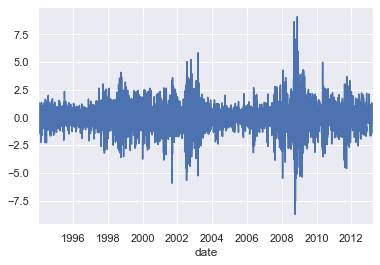

In [60]:
df['ar5_ma2_ret_resid'].plot()

(-0.06, 0.06)

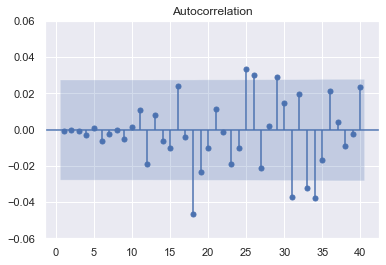

In [61]:
sgt.plot_acf(df['ar5_ma2_ret_resid'][1:],lags=40,zero=False)
plt.ylim(-0.06,0.06)

In [62]:
# here we see that 17 lags are not significant, We will not try and fit 18th lag because then we might lead to 
# overfitting the data.

## ARMA Models for Prices

In [63]:
# Here we will study the impact of ARMA model on non stationary data
# We saw that AR and MA model does not work well with non stationary data set

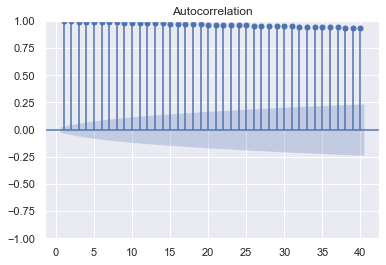

In [66]:
sgt.plot_acf(df['market_value'],lags=40,zero=False)
plt.show()

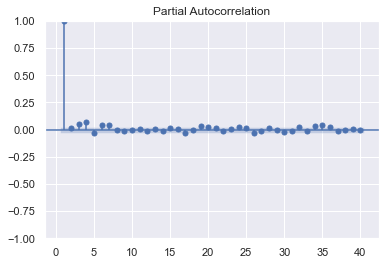

In [67]:
sgt.plot_pacf(df['market_value'],lags=40,zero=False,method=('ols'))
plt.show()

In [69]:
# ACF shows many lags are relevant this suggests MA infinity which is not possible
# We know that MA infinity is equivalent to AR model and thus its components can describe the data well

# Lets try AR1 MA 1 model on price data

In [70]:
ar1_ma1_price_model=ARIMA(df['market_value'],order=(1,0,1))
ar1_ma1_price_result=ar1_ma1_price_model.fit()
ar1_ma1_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27621.875
Date:                Sun, 17 Jul 2022   AIC                          55251.749
Time:                        23:05:19   BIC                          55277.835
Sample:                    01-07-1994   HQIC                         55260.890
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    366.501     13.887      0.000    4371.312    5807.970
ar.L1          0.9982      0.001   1189.159      0.000       0.997       1.000
ma.L1         -0.0186      0.010     -1.894      0.058      -0.038       0.001
sigma2      3510.8350     41.068     85.489      0.000    3430.344    3591.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3280.53
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
df['ar1_ma1_price_resid']=ar1_ma1_price_result.resid

In [ ]:
# We plot the acf of the residuals to check if the model was fit or not
# if the residual is random then good, if not then we take the significant lags in AR MA model

(-0.07, 0.07)

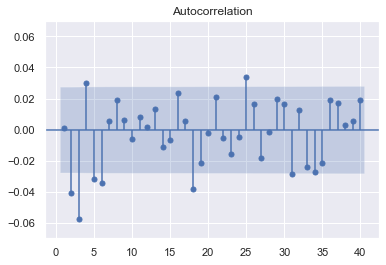

In [74]:
sgt.plot_acf(df['ar1_ma1_price_resid'],lags=40,zero=False)
plt.ylim(-0.07,0.07)

In [ ]:
# Here lets take ARMA(6,6)

In [75]:
ar6_ma6_price_model=ARIMA(df['market_value'],order=(6,0,6))
ar6_ma6_price_result=ar6_ma6_price_model.fit()
ar6_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27591.277
Date:                Mon, 18 Jul 2022   AIC                          55210.553
Time:                        06:32:42   BIC                          55301.853
Sample:                    01-07-1994   HQIC                         55242.546
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408    511.844      9.944      0.000    4086.445    6092.837
ar.L1          0.7382      0.926      0.797      0.426      -1.078       2.554
ar.L2          0.2445      1.555      0.157      0.875      -2.803       3.293
ar.L3         -0.4061      1.223     -0.332      0.740      -2.802       1.990
ar.L4          0.3422      0.759      0.451      0.652      -1.145       1.829
ar.L5         -0.1101      0.418     -0.263      0.792      -0.930       0.710
ar.L6          0.1892      0.254      0.746      0.456      -0.308       0.686
ma.L1          0.2406      0.926      0.260      0.795      -1.575       2.056
ma.L2         -0.0390      0.668     -0.058      0.953      -1.347       1.269
ma.L3          0.3344      0.562      0.595      0.552      -0.768       1.437
ma.L4          0.0823      0.243      0.339      0.735      -0.394       0.559
ma.L5          0.1450      0.301      0.482      0.630      -0.444       0.734
ma.L6         -0.0865      0.085     -1.016      0.309      -0.253       0.080
sigma2      3468.7432     43.249     80.204      0.000    3383.977    3553.510
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2960.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
# All the variables are statistically insignificant
# So lets start finding the lower level ARMA

In [77]:
ar5_ma6_price_model=ARIMA(df['market_value'],order=(5,0,6))
ar5_ma6_price_result=ar5_ma6_price_model.fit()
ar5_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(5, 0, 6)   Log Likelihood              -27589.604
Date:                Mon, 18 Jul 2022   AIC                          55205.208
Time:                        06:43:05   BIC                          55289.986
Sample:                    01-07-1994   HQIC                         55234.915
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6407   1387.898      3.667      0.000    2369.410    7809.871
ar.L1          0.7768      0.651      1.194      0.233      -0.499       2.052
ar.L2         -0.4256      0.740     -0.575      0.565      -1.876       1.025
ar.L3          0.2863      0.636      0.450      0.653      -0.961       1.534
ar.L4          0.4733      0.507      0.933      0.351      -0.521       1.467
ar.L5         -0.1117      0.105     -1.068      0.286      -0.317       0.093
ma.L1          0.1998      0.650      0.307      0.759      -1.075       1.474
ma.L2          0.6009      0.144      4.176      0.000       0.319       0.883
ma.L3          0.2545      0.520      0.489      0.625      -0.765       1.274
ma.L4         -0.1389      0.093     -1.492      0.136      -0.321       0.044
ma.L5         -0.0921      0.013     -7.331      0.000      -0.117      -0.067
ma.L6         -0.0388      0.068     -0.575      0.565      -0.171       0.093
sigma2      3464.1456     42.287     81.921      0.000    3381.265    3547.026
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3006.90
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
ar4_ma6_price_model=ARIMA(df['market_value'],order=(4,0,6))
ar4_ma6_price_result=ar4_ma6_price_model.fit()
ar4_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 6)   Log Likelihood              -27589.883
Date:                Mon, 18 Jul 2022   AIC                          55203.766
Time:                        06:43:12   BIC                          55282.022
Sample:                    01-07-1994   HQIC                         55231.188
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6407   3640.394      1.398      0.162   -2045.401    1.22e+04
ar.L1          0.5110      1.154      0.443      0.658      -1.752       2.774
ar.L2         -0.2572      1.365     -0.188      0.851      -2.933       2.419
ar.L3          0.1647      1.201      0.137      0.891      -2.188       2.518
ar.L4          0.5810      0.989      0.587      0.557      -1.358       2.520
ma.L1          0.4680      1.155      0.405      0.685      -1.796       2.732
ma.L2          0.6861      0.240      2.860      0.004       0.216       1.156
ma.L3          0.4648      0.937      0.496      0.620      -1.373       2.302
ma.L4         -0.0560      0.102     -0.551      0.582      -0.255       0.143
ma.L5         -0.0953      0.011     -8.674      0.000      -0.117      -0.074
ma.L6         -0.0587      0.113     -0.521      0.602      -0.279       0.162
sigma2      3448.7987     41.835     82.438      0.000    3366.804    3530.794
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3022.66
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
ar3_ma6_price_model=ARIMA(df['market_value'],order=(3,0,6))
ar3_ma6_price_result=ar3_ma6_price_model.fit()
ar3_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 6)   Log Likelihood              -27589.832
Date:                Mon, 18 Jul 2022   AIC                          55201.665
Time:                        06:43:19   BIC                          55273.400
Sample:                    01-07-1994   HQIC                         55226.801
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6406   3008.432      1.692      0.091    -806.777     1.1e+04
ar.L1          1.1848      0.045     26.130      0.000       1.096       1.274
ar.L2         -1.0454      0.067    -15.504      0.000      -1.178      -0.913
ar.L3          0.8603      0.042     20.596      0.000       0.778       0.942
ma.L1         -0.2055      0.046     -4.496      0.000      -0.295      -0.116
ma.L2          0.8146      0.044     18.636      0.000       0.729       0.900
ma.L3         -0.0852      0.013     -6.590      0.000      -0.111      -0.060
ma.L4          0.0009      0.012      0.073      0.942      -0.022       0.024
ma.L5         -0.0944      0.010     -9.064      0.000      -0.115      -0.074
ma.L6          0.0024      0.011      0.225      0.822      -0.019       0.024
sigma2      3465.6305     42.196     82.131      0.000    3382.927    3548.334
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3029.97
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
ar2_ma6_price_model=ARIMA(df['market_value'],order=(2,0,6))
ar2_ma6_price_result=ar2_ma6_price_model.fit()
ar2_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(2, 0, 6)   Log Likelihood              -27593.064
Date:                Mon, 18 Jul 2022   AIC                          55206.128
Time:                        06:43:21   BIC                          55271.342
Sample:                    01-07-1994   HQIC                         55228.980
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408    512.826      9.925      0.000    4084.520    6094.762
ar.L1          0.8774      0.264      3.318      0.001       0.359       1.396
ar.L2          0.1214      0.264      0.460      0.646      -0.396       0.639
ma.L1          0.1017      0.264      0.385      0.700      -0.416       0.620
ma.L2         -0.0507      0.011     -4.789      0.000      -0.071      -0.030
ma.L3         -0.0799      0.017     -4.793      0.000      -0.113      -0.047
ma.L4          0.0228      0.022      1.027      0.304      -0.021       0.066
ma.L5         -0.0255      0.012     -2.092      0.036      -0.049      -0.002
ma.L6         -0.0395      0.012     -3.244      0.001      -0.063      -0.016
sigma2      3479.5283     42.328     82.203      0.000    3396.566    3562.491
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3031.68
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
ar1_ma6_price_model=ARIMA(df['market_value'],order=(1,0,6))
ar1_ma6_price_result=ar1_ma6_price_model.fit()
ar1_ma6_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 6)   Log Likelihood              -27593.249
Date:                Mon, 18 Jul 2022   AIC                          55204.499
Time:                        06:43:22   BIC                          55263.191
Sample:                    01-07-1994   HQIC                         55225.065
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    421.444     12.077      0.000    4263.626    5915.655
ar.L1          0.9987      0.001   1437.026      0.000       0.997       1.000
ma.L1         -0.0192      0.010     -1.881      0.060      -0.039       0.001
ma.L2         -0.0479      0.009     -5.166      0.000      -0.066      -0.030
ma.L3         -0.0740      0.009     -8.066      0.000      -0.092      -0.056
ma.L4          0.0325      0.009      3.491      0.000       0.014       0.051
ma.L5         -0.0291      0.009     -3.183      0.001      -0.047      -0.011
ma.L6         -0.0353      0.010     -3.601      0.000      -0.054      -0.016
sigma2      3481.9482     42.301     82.315      0.000    3399.041    3564.856
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3028.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
ar6_ma5_price_model=ARIMA(df['market_value'],order=(6,0,5))
ar6_ma5_price_result=ar6_ma5_price_model.fit()
ar6_ma5_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 5)   Log Likelihood              -27591.218
Date:                Mon, 18 Jul 2022   AIC                          55208.436
Time:                        06:43:24   BIC                          55293.214
Sample:                    01-07-1994   HQIC                         55238.143
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    464.982     10.946      0.000    4178.292    6000.990
ar.L1          1.5085      0.158      9.556      0.000       1.199       1.818
ar.L2         -1.0305      0.237     -4.353      0.000      -1.495      -0.566
ar.L3          0.5858      0.229      2.559      0.011       0.137       1.034
ar.L4         -0.0897      0.222     -0.404      0.687      -0.525       0.346
ar.L5         -0.0792      0.200     -0.395      0.693      -0.472       0.313
ar.L6          0.1038      0.106      0.978      0.328      -0.104       0.312
ma.L1         -0.5298      0.159     -3.330      0.001      -0.842      -0.218
ma.L2          0.4825      0.155      3.117      0.002       0.179       0.786
ma.L3         -0.1250      0.123     -1.014      0.311      -0.367       0.117
ma.L4          0.0712      0.132      0.540      0.589      -0.187       0.330
ma.L5          0.0183      0.111      0.164      0.869      -0.200       0.237
sigma2      3475.9064     43.309     80.257      0.000    3391.021    3560.791
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2973.26
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
ar6_ma4_price_model=ARIMA(df['market_value'],order=(6,0,4))
ar6_ma4_price_result=ar6_ma4_price_model.fit()
ar6_ma4_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 4)   Log Likelihood              -27591.314
Date:                Mon, 18 Jul 2022   AIC                          55206.629
Time:                        06:43:28   BIC                          55284.885
Sample:                    01-07-1994   HQIC                         55234.051
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6409    438.002     11.620      0.000    4231.172    5948.110
ar.L1          1.5560      0.144     10.813      0.000       1.274       1.838
ar.L2         -1.1148      0.218     -5.103      0.000      -1.543      -0.687
ar.L3          0.6360      0.197      3.222      0.001       0.249       1.023
ar.L4         -0.1630      0.198     -0.824      0.410      -0.551       0.225
ar.L5         -0.0047      0.106     -0.045      0.964      -0.212       0.202
ar.L6          0.0891      0.013      6.662      0.000       0.063       0.115
ma.L1         -0.5772      0.145     -3.987      0.000      -0.861      -0.293
ma.L2          0.5203      0.126      4.142      0.000       0.274       0.767
ma.L3         -0.1366      0.118     -1.154      0.249      -0.369       0.095
ma.L4          0.1337      0.114      1.177      0.239      -0.089       0.356
sigma2      3474.5939     43.206     80.419      0.000    3389.911    3559.276
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2954.28
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
ar6_ma3_price_model=ARIMA(df['market_value'],order=(6,0,3))
ar6_ma3_price_result=ar6_ma3_price_model.fit()
ar6_ma3_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 3)   Log Likelihood              -27595.668
Date:                Mon, 18 Jul 2022   AIC                          55213.336
Time:                        06:43:35   BIC                          55285.072
Sample:                    01-07-1994   HQIC                         55238.473
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6406    423.067     12.030      0.000    4260.444    5918.837
ar.L1          0.0990      0.269      0.368      0.713      -0.428       0.626
ar.L2         -0.0404      0.072     -0.563      0.573      -0.181       0.100
ar.L3          0.7722      0.063     12.217      0.000       0.648       0.896
ar.L4          0.0859      0.193      0.446      0.656      -0.292       0.464
ar.L5          0.0307      0.021      1.442      0.149      -0.011       0.072
ar.L6          0.0483      0.018      2.624      0.009       0.012       0.084
ma.L1          0.8813      0.269      3.281      0.001       0.355       1.408
ma.L2          0.8747      0.252      3.470      0.001       0.381       1.369
ma.L3          0.0304      0.205      0.148      0.882      -0.372       0.433
sigma2      3476.7770     42.537     81.736      0.000    3393.406    3560.147
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2972.95
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
ar6_ma2_price_model=ARIMA(df['market_value'],order=(6,0,2))
ar6_ma2_price_result=ar6_ma2_price_model.fit()
ar6_ma2_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -27590.600
Date:                Mon, 18 Jul 2022   AIC                          55201.200
Time:                        06:43:40   BIC                          55266.414
Sample:                    01-07-1994   HQIC                         55224.051
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408   1478.103      3.443      0.001    2192.612    7986.670
ar.L1          1.1938      0.051     23.393      0.000       1.094       1.294
ar.L2         -1.0582      0.070    -15.012      0.000      -1.196      -0.920
ar.L3          0.7824      0.047     16.600      0.000       0.690       0.875
ar.L4          0.0840      0.018      4.542      0.000       0.048       0.120
ar.L5         -0.0939      0.015     -6.102      0.000      -0.124      -0.064
ar.L6          0.0912      0.010      9.210      0.000       0.072       0.111
ma.L1         -0.2144      0.050     -4.322      0.000      -0.312      -0.117
ma.L2          0.8216      0.045     18.152      0.000       0.733       0.910
sigma2      3477.2352     42.351     82.105      0.000    3394.228    3560.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3014.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
ar6_ma1_price_model=ARIMA(df['market_value'],order=(6,0,1))
ar6_ma1_price_result=ar6_ma1_price_model.fit()
ar6_ma1_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(6, 0, 1)   Log Likelihood              -27594.195
Date:                Mon, 18 Jul 2022   AIC                          55206.390
Time:                        06:43:45   BIC                          55265.082
Sample:                    01-07-1994   HQIC                         55226.956
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6310    525.409      9.687      0.000    4059.849    6119.413
ar.L1          1.3885      0.158      8.795      0.000       1.079       1.698
ar.L2         -0.4334      0.154     -2.813      0.005      -0.735      -0.131
ar.L3         -0.0103      0.017     -0.618      0.536      -0.043       0.022
ar.L4          0.1125      0.016      6.905      0.000       0.081       0.144
ar.L5         -0.1154      0.020     -5.696      0.000      -0.155      -0.076
ar.L6          0.0573      0.009      6.194      0.000       0.039       0.075
ma.L1         -0.4091      0.158     -2.583      0.010      -0.719      -0.099
sigma2      3471.4180     42.110     82.437      0.000    3388.884    3553.952
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              3031.82
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
ar4_ma5_price_model=ARIMA(df['market_value'],order=(4,0,5))
ar4_ma5_price_result=ar4_ma5_price_model.fit()
ar4_ma5_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(4, 0, 5)   Log Likelihood              -27589.941
Date:                Mon, 18 Jul 2022   AIC                          55201.882
Time:                        06:48:21   BIC                          55273.618
Sample:                    01-07-1994   HQIC                         55227.019
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6407   3350.195      1.519      0.129   -1476.621    1.17e+04
ar.L1          1.1937      0.110     10.817      0.000       0.977       1.410
ar.L2         -1.0551      0.122     -8.644      0.000      -1.294      -0.816
ar.L3          0.8733      0.111      7.887      0.000       0.656       1.090
ar.L4         -0.0121      0.099     -0.122      0.903      -0.206       0.182
ma.L1         -0.2144      0.109     -1.959      0.050      -0.429    5.46e-05
ma.L2          0.8154      0.041     19.906      0.000       0.735       0.896
ma.L3         -0.0965      0.093     -1.034      0.301      -0.279       0.086
ma.L4         -0.0011      0.011     -0.099      0.921      -0.022       0.020
ma.L5         -0.0929      0.010     -8.889      0.000      -0.113      -0.072
sigma2      3457.9863     42.008     82.317      0.000    3375.652    3540.321
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3038.75
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
ar3_ma5_price_model=ARIMA(df['market_value'],order=(3,0,5))
ar3_ma5_price_result=ar3_ma5_price_model.fit()
ar3_ma5_price_result.coeff

AttributeError: 'ARIMAResults' object has no attribute 'coeff'

In [95]:
ar3_ma4_price_model=ARIMA(df['market_value'],order=(3,0,4))
ar3_ma4_price_result=ar3_ma4_price_model.fit()
ar3_ma4_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(3, 0, 4)   Log Likelihood              -27597.939
Date:                Mon, 18 Jul 2022   AIC                          55213.878
Time:                        06:51:40   BIC                          55272.570
Sample:                    01-07-1994   HQIC                         55234.444
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6408    534.090      9.530      0.000    4042.843    6136.439
ar.L1          0.8195      5.028      0.163      0.871      -9.036      10.675
ar.L2          0.2295      3.171      0.072      0.942      -5.986       6.445
ar.L3         -0.0501      1.854     -0.027      0.978      -3.684       3.584
ma.L1          0.1604      5.028      0.032      0.975      -9.694      10.015
ma.L2         -0.1048      1.761     -0.060      0.953      -3.555       3.346
ma.L3         -0.0888      0.292     -0.305      0.761      -0.660       0.483
ma.L4          0.0188      0.500      0.038      0.970      -0.961       0.999
sigma2      3483.0503     42.407     82.133      0.000    3399.934    3566.167
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2967.65
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

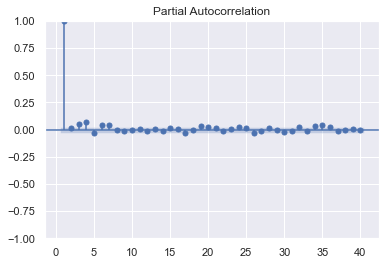

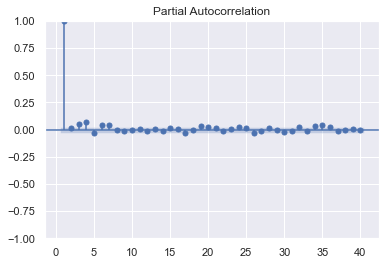

In [97]:
sgt.plot_pacf(df['market_value'],lags=40,zero=False,method=('ols'))

In [100]:
ar7_ma2_price_model=ARIMA(df['market_value'],order=(7,0,2))
ar7_ma2_price_result=ar7_ma2_price_model.fit()
ar7_ma2_price_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(7, 0, 2)   Log Likelihood              -27590.660
Date:                Mon, 18 Jul 2022   AIC                          55203.320
Time:                        07:12:27   BIC                          55275.055
Sample:                    01-07-1994   HQIC                         55228.457
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6405   1619.457      3.143      0.002    1915.564    8263.717
ar.L1          1.1939      0.055     21.629      0.000       1.086       1.302
ar.L2         -1.0573      0.083    -12.755      0.000      -1.220      -0.895
ar.L3          0.7814      0.053     14.830      0.000       0.678       0.885
ar.L4          0.0841      0.019      4.394      0.000       0.047       0.122
ar.L5         -0.0940      0.018     -5.153      0.000      -0.130      -0.058
ar.L6          0.0912      0.018      5.175      0.000       0.057       0.126
ar.L7       3.043e-05      0.011      0.003      0.998      -0.021       0.021
ma.L1         -0.2145      0.054     -4.002      0.000      -0.320      -0.109
ma.L2          0.8207      0.050     16.251      0.000       0.722       0.920
sigma2      3463.9235     42.065     82.347      0.000    3381.478    3546.369
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3015.64
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [101]:
#analyzing the residual of ar6 ma 2

In [102]:
df['ar6_ma2_price_resid']=ar6_ma2_price_result.resid

(-0.04, 0.04)

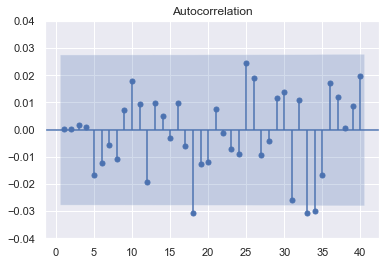

In [108]:
sgt.plot_acf(df['ar6_ma2_price_resid'],lags=40,zero=False)
plt.ylim(-0.04,0.04)

#### Note
- Even though we applied ARMA model on non stationary data and the result was fit but we can see that 
- the Log likelihood is in -15k while for returns it was in -7k so for stationary data (returns) work better

## ARMA for Returns vs ARMA for Prices

#### Note
- Even though we applied ARMA model on non stationary data and the result was fit but we can see that 
- the Log likelihood is in -15k while for returns it was in -7k so for stationary data (returns) work better